# Critical Factors in Hospital Patient Satisfaction

The HCAHPS (the Hospital Consumer Assessment of Healthcare Providers and Systems) is a patient satisfaction survey
required by CMS (the Centers for Medicare and Medicaid Services) for all hospitals in the United States. Patients
are asked a total of 32 questions regarding their hospital stay.  Achieving good scores on the HCAHPS survey is of
critical importance to hospitals.  CMS raises and lowers Medicare reimbursement rates based in part on a hospital's
HCAHPS survey results. [Strong correlations have been found between HCAHPS results and hospital profitability.](http://www.apihealthcare.com/blog/healthcare-trends/patient-satisfaction-and-the-bottom-line)

This paper will explore the reported HCAHPS data to identify how hospitals can improve overall patient satisfaction.

The reported HCAHPS data will be divided into 3 categories of reponses:

#### Group A: Individual Question Patient Response Percentages

"Patients who reported that..."

1. they Sometimes or Never received help as soon as they wanted
2. they Always received help as soon as they wanted
3. YES, they were given information about what to do during their recovery at home
4. the area around their room was Always quiet at night
5. their nurses Sometimes or Never communicated well
6. their room and bathroom were Usually clean
7. area around their room was Sometimes or Never quiet at night
8. their doctors Sometimes or Never communicated well
9. their room and bathroom were Sometimes or Never clean
10. their doctors Usually communicated well
11. they Usually received help as soon as they wanted
12. their nurses Always communicated well
13. they Sometimes or Never received help as soon as they wanted
14. their pain was Sometimes or Never well controlled
15. staff Sometimes or Never explained about medicines before giving it to them
16. their pain was Usually well controlled
17. staff Always explained about medicines before giving it to them
18. their doctors Always communicated well
19. their room and bathroom were Always clean
21. their pain was Always well controlled
22. staff Usually explained about medicines before giving it to them
23. NO, they were not given information about what to do during their recovery at home
24. the area around their room was Sometimes or Never quiet at night

#### Group B: Overall Hospital Satisfaction Percentages

"Patients who..."

1. gave their hospital a rating of 6 or lower on a scale from 0 (lowest) to 10 (highest)
2. gave their hospital a rating of 7 or 8 on a scale from 0 (lowest) to 10 (highest)
3. who gave their hospital a rating of 9 or 10 on a scale from 0 (lowest) to 10 (highest)
4. reported NO, they would probably not or definitely not recommend the hospital
5. reported YES, they would probably recommend the hospital
6. reported YES, they would definitely recommend the hospital 

#### Group C: Linear Means and Star Ratings (HCAHPS calculates linear means and star ratings for these categories)

1. Communication with doctors
2. Communication with nurses
3. Responsiveness of hospital staff
4. Pain management
5. Communication about medicines
6. Discharge information
7. Cleanliness of the hospital environment
8. Quietness of the hospital environment
9. Transition of care
10. Overall hospital rating
11. Recommnedation of hospital

Since we are doing our own calculations, we will ignore Group C.

This study will explore correlations between Group A reponse percentages and the Group B response, "Patients
who reported NO, they would probably not or definitely not recommend the hospital." By examining what correlations
exist between Group A questions and a "NO" recommendation, we hope to discover what individiaul patient 
responses from Group A are driving a negative overall hospital eperience.

This study will first examine the correlations through univariate linear regression in which each of the
Group A questions will be individually contrasted against "NO" recommendations.  The study will
then construct a multiple linear regression model, train the model with a subset of data, and determine
how well the model can predict a "No" recommendation reponse based on Group A survey data.  Finally, using
recursive feature elimination, the study will determine which Group A questions are relavant in predicting a "No" 
recommendation result.

## Results Summary

Individual linear regressions determined the following questions were most correlated with a "NO"
recommendation:
    
    1. Patients who reported that their nurses Sometimes or Never communicated well
    2. Patients who disagree or strongly disagree they understood their care when they left the hospital
    3. Patients who reported they someimes or never received help as soon as they wanted
    
A multiple linear reression model was constructed, and determined to be reasonably effective at predicting 
"NO" recommendation results based on Group A question percentages.  Using recursive feature elimination the model
shows that the drivers of patient satisfaction in order of importance are:
    
    
    1. Nurse Communication
    2. Pain Management
    3. Doctor Communication
    4. Recovery Information
    5. Room and Bathroom Cleanliness
    6. Understanding of Care on Leaving Hospital
    7. Timely Help When Wanted
    8. Quietness at Night
    9. Staff Explanations of Medicines

In [102]:
import pandas as pd
df = pd.read_csv('Patient_survey__HCAHPS__-_Hospital.csv')
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 15})

# Column names include blank spaces.  Will replace blank spaces in colun names with a '_'

df.columns = df.columns.str.replace('\s+', '_')

# Clean problematic characters from question column

df['HCAHPS_Question'] = df['HCAHPS_Question'].str.replace('"','')
df['HCAHPS_Question'] = df['HCAHPS_Question'].str.replace("'","")
df['HCAHPS_Question'] = df['HCAHPS_Question'].str.replace('\x93','')
df['HCAHPS_Question'] = df['HCAHPS_Question'].str.replace('\x94','')
from scipy import stats

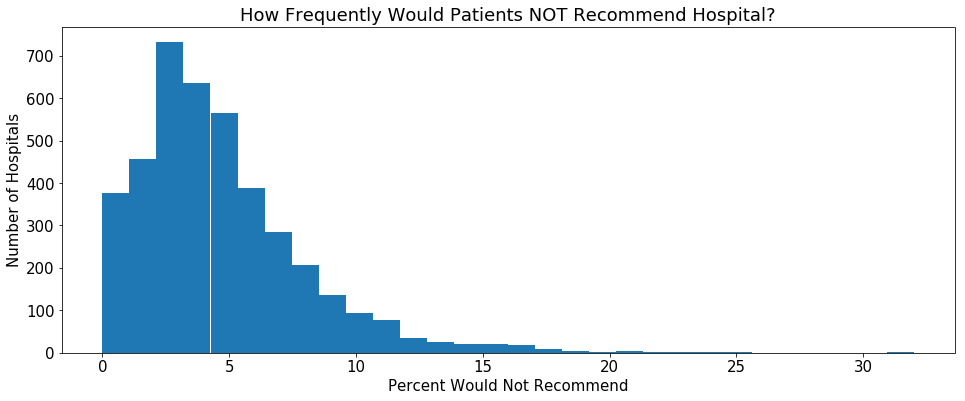

In [103]:
# Generate Histrogram of NO Recommend Answers

no_rec_df = df[df.HCAHPS_Question == 'Patients who reported NO, they would probably not or definitely not recommend the hospital']
no_rec_df = no_rec_df[no_rec_df.HCAHPS_Answer_Percent != 'Not Available']

#len(no_rec_df)
# 4103 hospitals contain 'no' percentage data, same as with 'yes' data from above

# Generate histogram showing percent of patients who would not recommend hospital

no_rec_percent = no_rec_df.HCAHPS_Answer_Percent
no_int = no_rec_percent.astype(int)

plt.figure(figsize=(16, 6))
plt.hist(no_int, bins = 30)
plt.xlabel('Percent Would Not Recommend')
plt.ylabel('Number of Hospitals')
plt.title('How Frequently Would Patients NOT Recommend Hospital?')
plt.show()

In [104]:
# Function will plot histogram and least squared regression for a given question's value, and add r-squared
# values to lists


r2_questions = []
r2_values = []
plt.rcParams.update({'font.size': 15})

def plot_histogram_and_regression_questions(question):
  question_frame = df[df.HCAHPS_Question == question]

  # remove bad fields
  question_frame = question_frame[question_frame.HCAHPS_Answer_Percent != 'Not Available']
  question_frame = question_frame[question_frame.HCAHPS_Answer_Percent != 'Not Applicable']

    
  # generate ineteger values
  answer_value = question_frame.HCAHPS_Answer_Percent
  answer_value_int = answer_value.astype(int)

  # Print Question for title
 

  # plot histogram  
  plt.figure(figsize=(20, 5))
  plt.suptitle(question)
  plt.subplot(1,2,1)
  plt.hist(answer_value_int, bins = 20)
  plt.xlabel('Answer Percent')
  plt.ylabel('Number of Hospitals')
  plt.title('Histogram')

  # Regression

  # merge questions and 'NO' reponses
  question_and_no_pd = pd.merge(question_frame, no_rec_df, on='Provider_ID')
  x_answer_percent = question_and_no_pd.HCAHPS_Answer_Percent_x
  x_answer_percent_int = x_answer_percent.astype(int)
  y_no_recommend = question_and_no_pd.HCAHPS_Answer_Percent_y
  y_no_recommend_int = y_no_recommend.astype(int)

  # create regression variables
  slope, intercept, r_value, p_value, std_err = stats.linregress(x_answer_percent_int, y_no_recommend_int)

  # plot regression
  plt.subplot(1,2,2)
  plt.scatter(x = x_answer_percent_int, y = y_no_recommend_int)
  plt.plot(x_answer_percent_int, intercept + slope*x_answer_percent_int, 'r', label='Least Squares Fitted Line')
  plt.xlabel('Answer Percent')
  plt.ylabel('Percent NO Recommend')
  plt.title('Regression')
  plt.show()

  print('slope:', slope, 'intercept:', intercept, 'r_value:', r_value, 'p_value:', p_value, 'std_err:', std_err, 'r-squared:', r_value**2)
  r2_questions.append(question)
  r2_values.append(r_value**2)


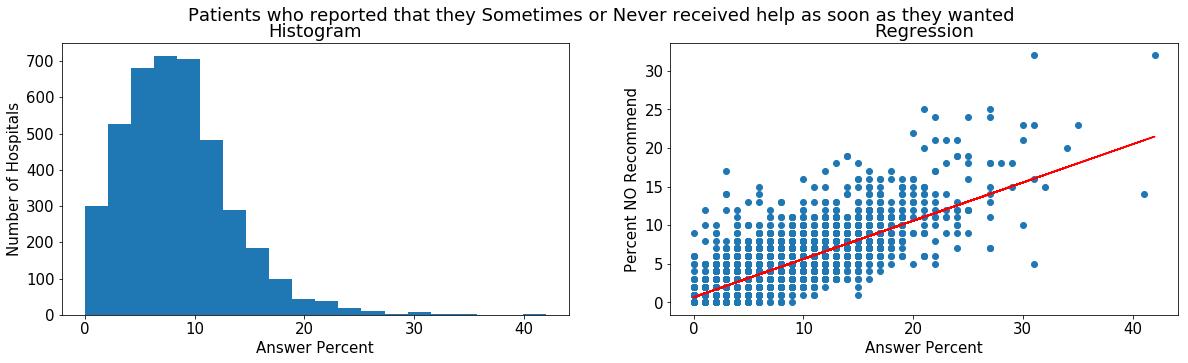

slope: 0.49584723606 intercept: 0.66066671162 r_value: 0.724008627968 p_value: 0.0 std_err: 0.0073769483142 r-squared: 0.524188493372


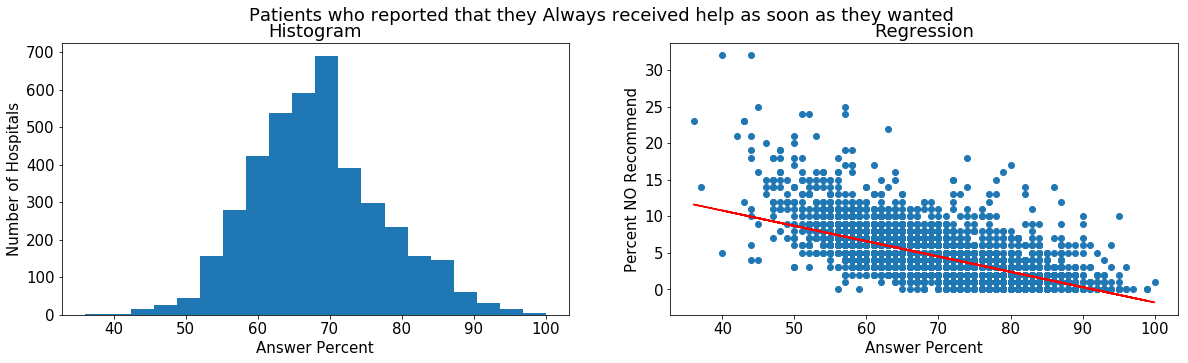

slope: -0.209516056911 intercept: 19.1553411715 r_value: -0.583367883334 p_value: 0.0 std_err: 0.00455509249293 r-squared: 0.340318087306


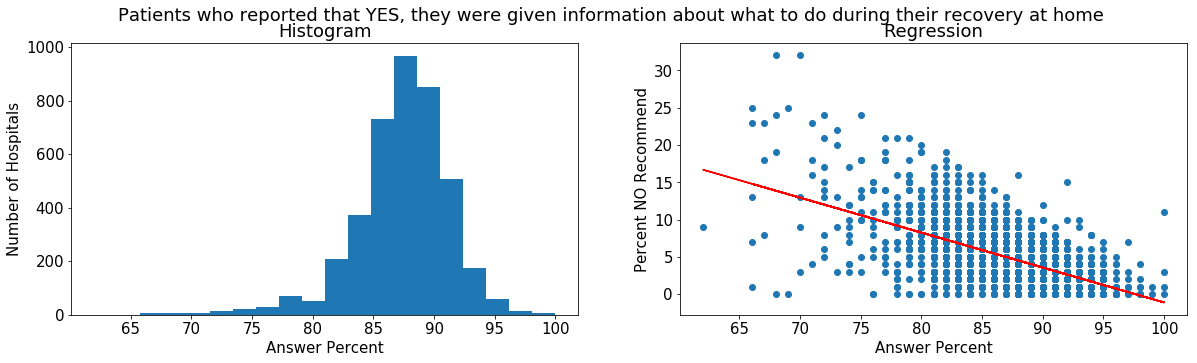

slope: -0.467887177215 intercept: 45.6945453538 r_value: -0.581088938418 p_value: 0.0 std_err: 0.0102327582629 r-squared: 0.337664354352


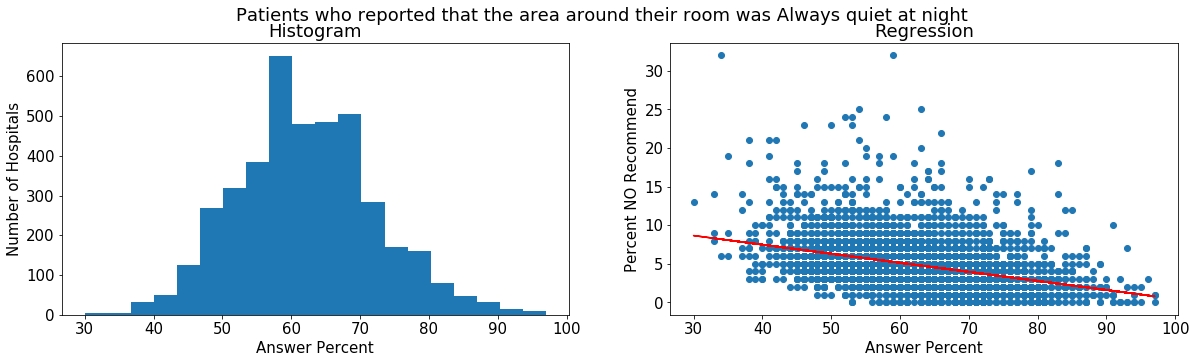

slope: -0.117484387838 intercept: 12.1801865316 r_value: -0.362929366322 p_value: 5.74380770011e-128 std_err: 0.00471024645062 r-squared: 0.131717724939


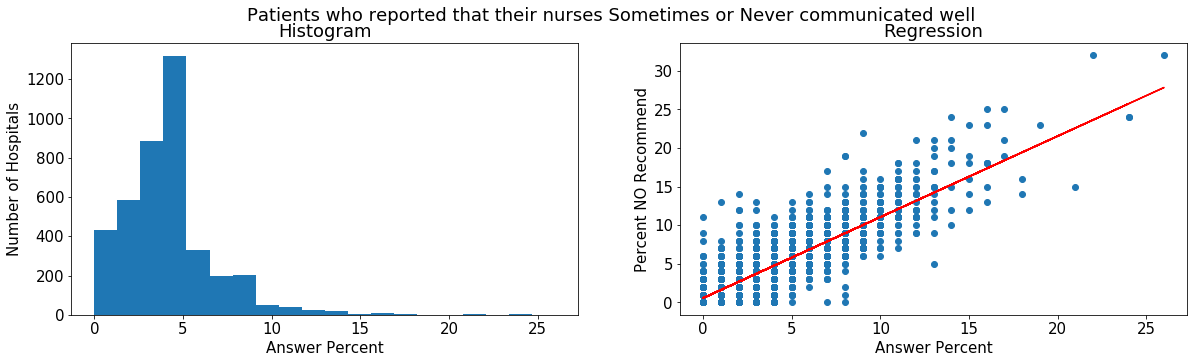

slope: 1.04947557922 intercept: 0.556994145415 r_value: 0.825906126404 p_value: 0.0 std_err: 0.0111873630532 r-squared: 0.682120929631


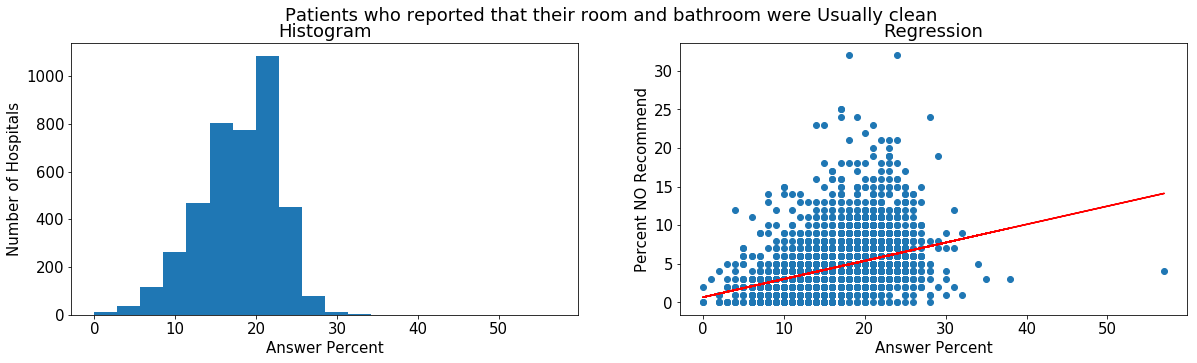

slope: 0.235955283017 intercept: 0.669245919224 r_value: 0.340408982123 p_value: 7.68506559066e-112 std_err: 0.0101774702401 r-squared: 0.11587827511


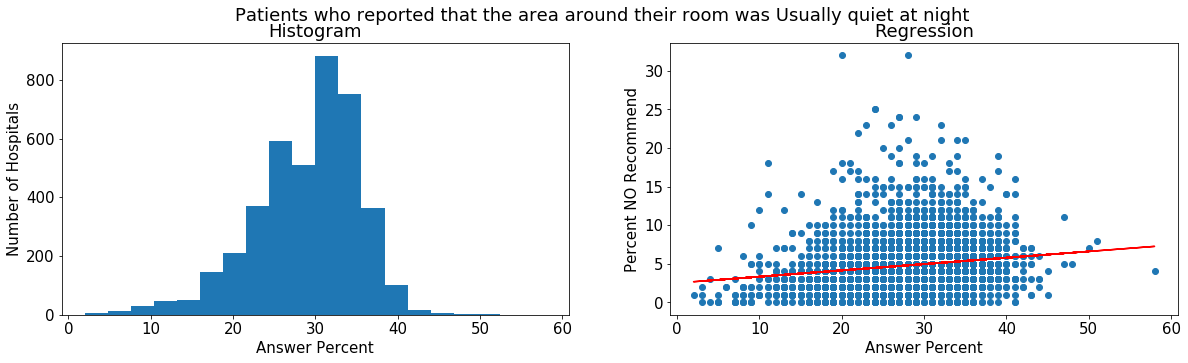

slope: 0.0817846048423 intercept: 2.51105505977 r_value: 0.160068196421 p_value: 5.93009673953e-25 std_err: 0.00787563167064 r-squared: 0.0256218275055


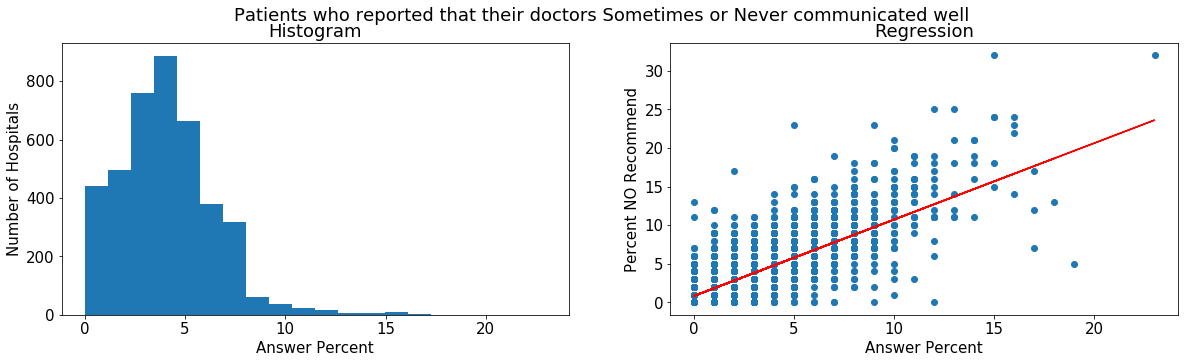

slope: 0.991345394428 intercept: 0.814849655561 r_value: 0.704909800013 p_value: 0.0 std_err: 0.0155766713612 r-squared: 0.496897826154


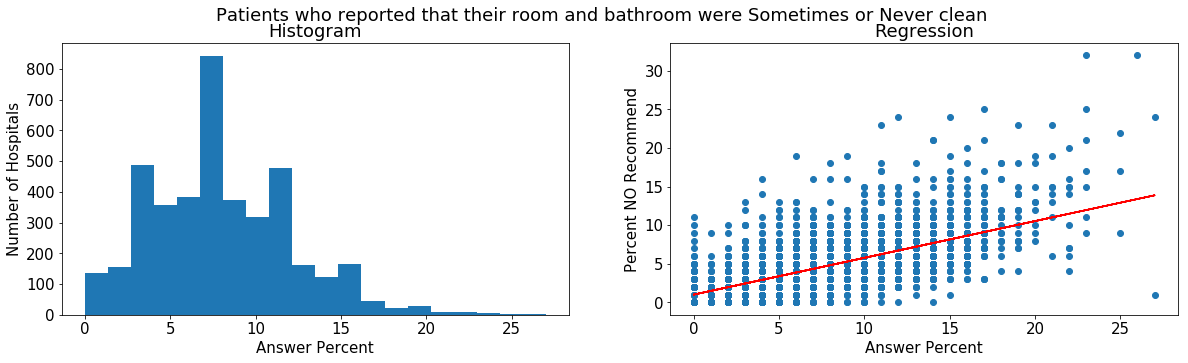

slope: 0.476588247185 intercept: 1.0035839668 r_value: 0.602559623404 p_value: 0.0 std_err: 0.00985692626527 r-squared: 0.363078099756


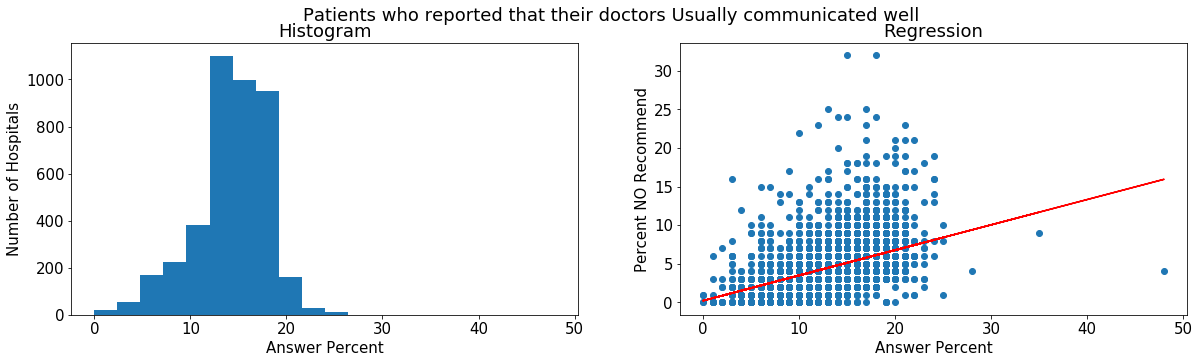

slope: 0.327781556846 intercept: 0.215996905653 r_value: 0.386717631363 p_value: 1.78549358672e-146 std_err: 0.0122059030001 r-squared: 0.149550526407


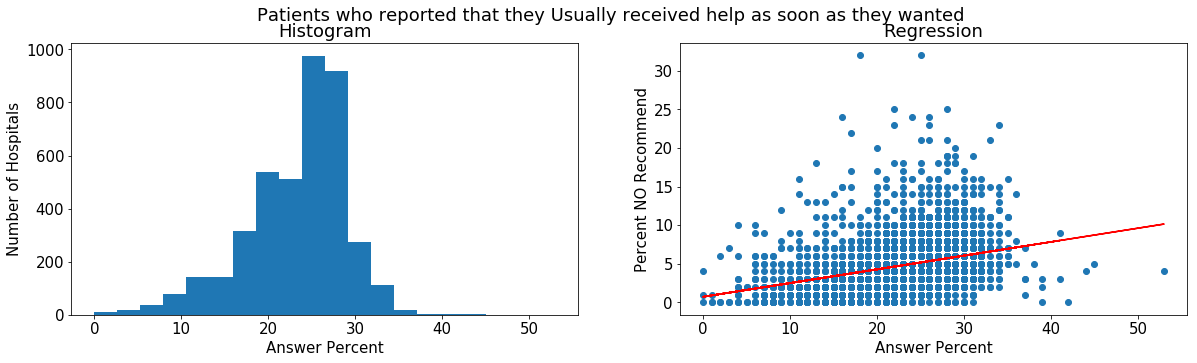

slope: 0.177828759445 intercept: 0.722605995481 r_value: 0.317577196027 p_value: 8.32293915684e-97 std_err: 0.00829129952753 r-squared: 0.100855275437


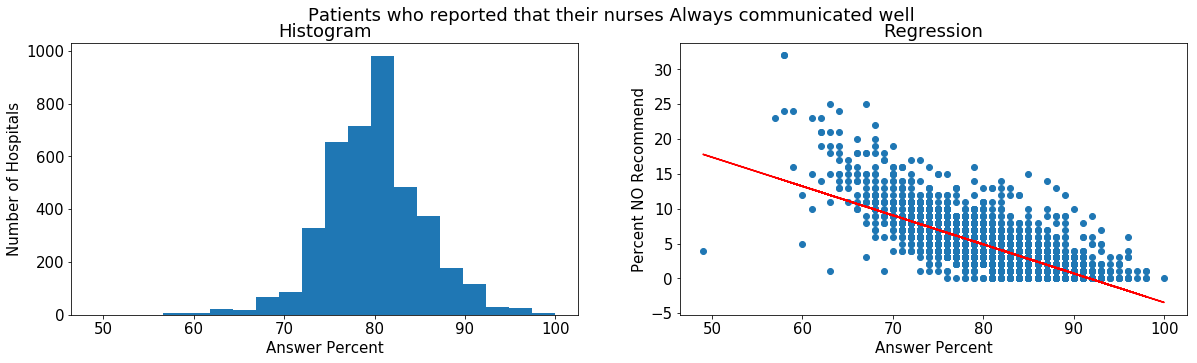

slope: -0.416872185567 intercept: 38.2345199156 r_value: -0.697543637243 p_value: 0.0 std_err: 0.00668695636288 r-squared: 0.486567125859


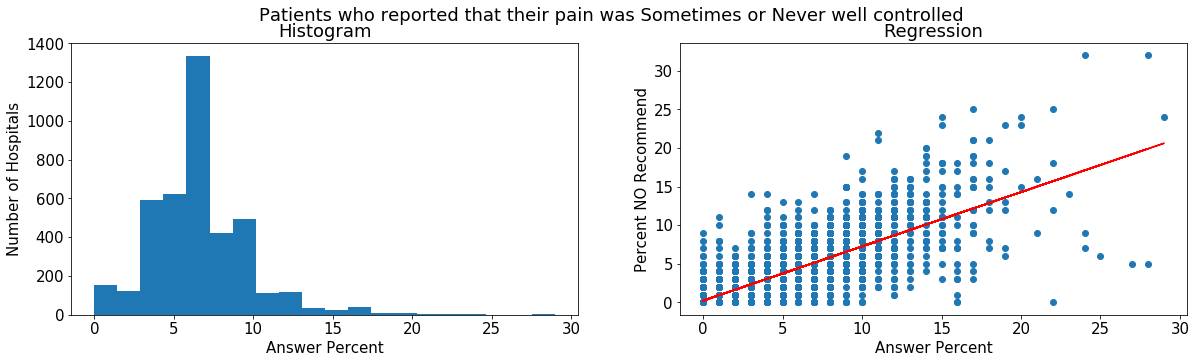

slope: 0.703488249741 intercept: 0.218357768836 r_value: 0.686145381179 p_value: 0.0 std_err: 0.0116468260666 r-squared: 0.470795484113


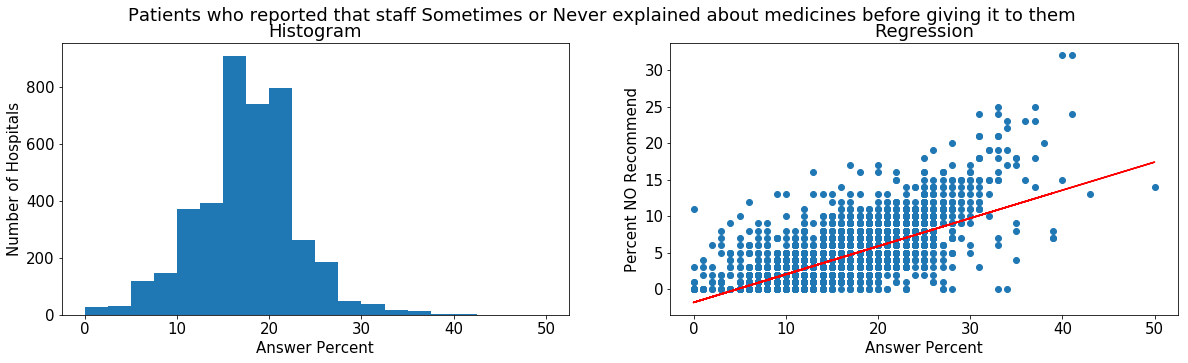

slope: 0.384173836556 intercept: -1.80825409284 r_value: 0.642438515842 p_value: 0.0 std_err: 0.007156015227 r-squared: 0.412727246637


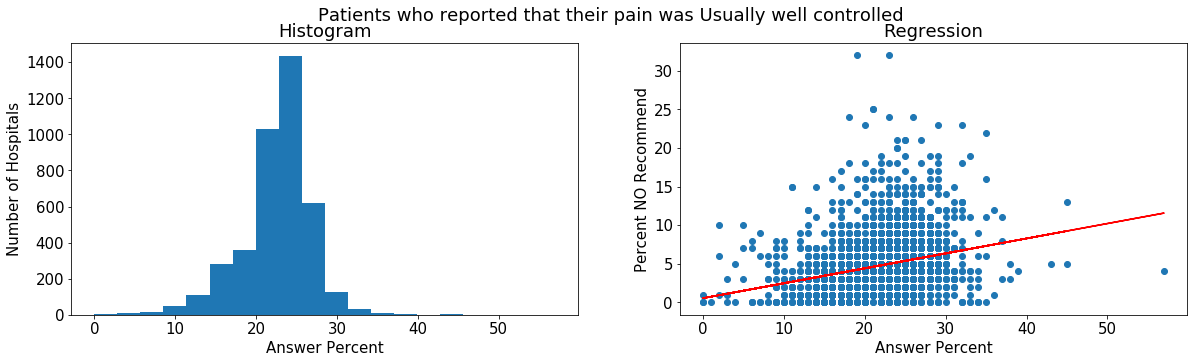

slope: 0.193449213083 intercept: 0.544261097219 r_value: 0.257666296291 p_value: 3.20221675292e-63 std_err: 0.0113278311954 r-squared: 0.0663919202445


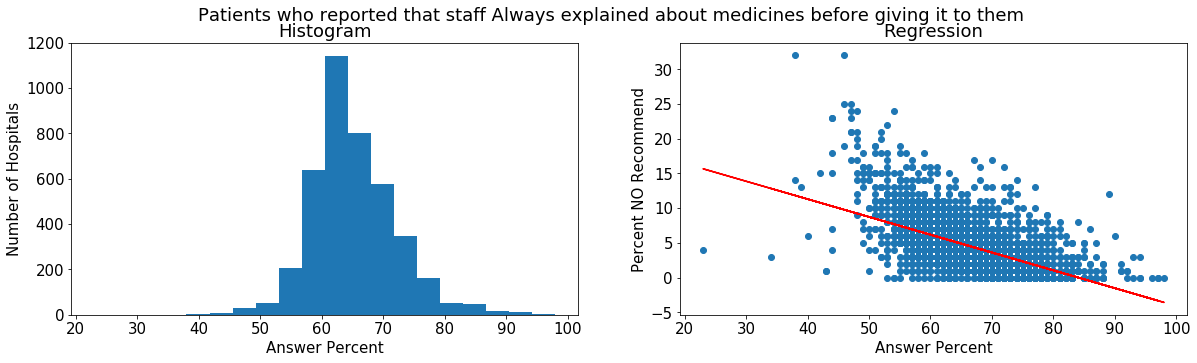

slope: -0.256725471153 intercept: 21.5789100786 r_value: -0.544210625438 p_value: 0.0 std_err: 0.00618005620082 r-squared: 0.29616520484


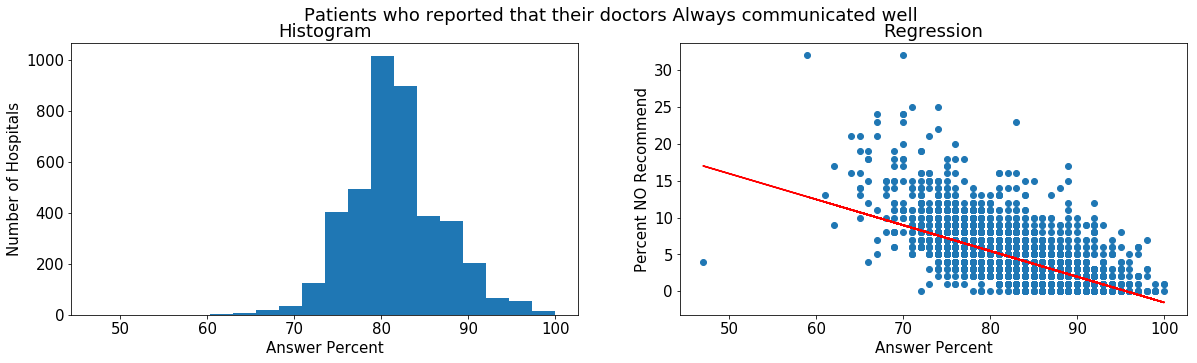

slope: -0.349706471545 intercept: 33.4439925982 r_value: -0.578652912482 p_value: 0.0 std_err: 0.00769668950738 r-squared: 0.334839193123


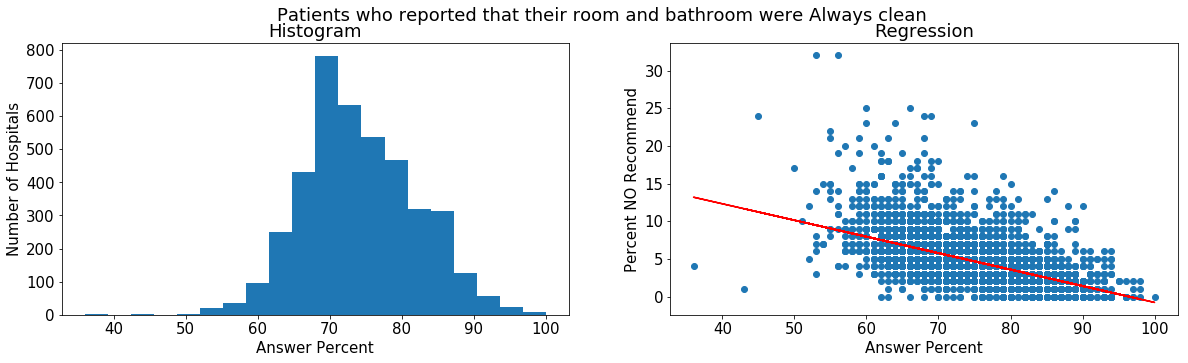

slope: -0.218288988122 intercept: 21.0409650344 r_value: -0.522973130119 p_value: 6.90633713393e-287 std_err: 0.00555552503654 r-squared: 0.273500894826


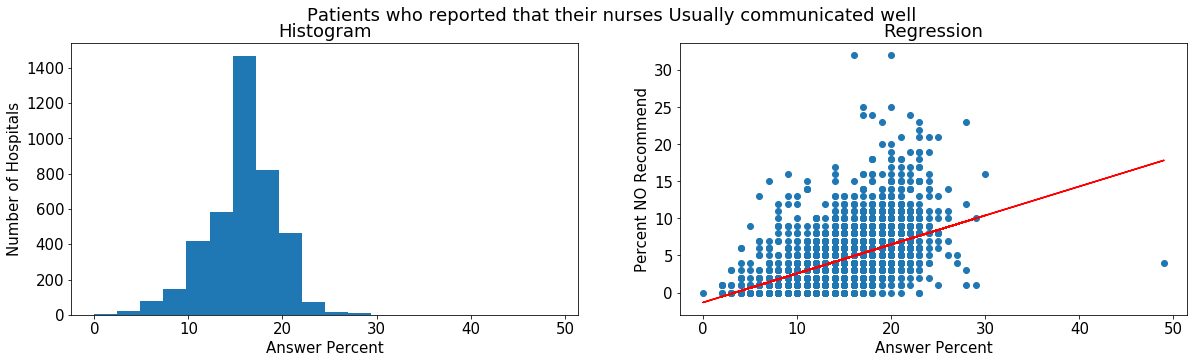

slope: 0.391530622565 intercept: -1.33681207829 r_value: 0.450009076815 p_value: 8.54068790118e-204 std_err: 0.01213284636 r-squared: 0.202508169216


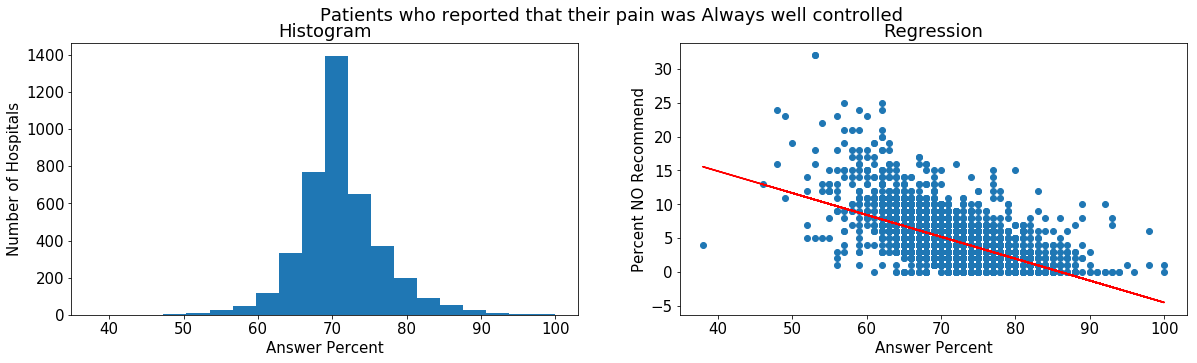

slope: -0.32337527371 intercept: 27.8359452535 r_value: -0.572184497586 p_value: 0.0 std_err: 0.00723778788435 r-squared: 0.327395099278


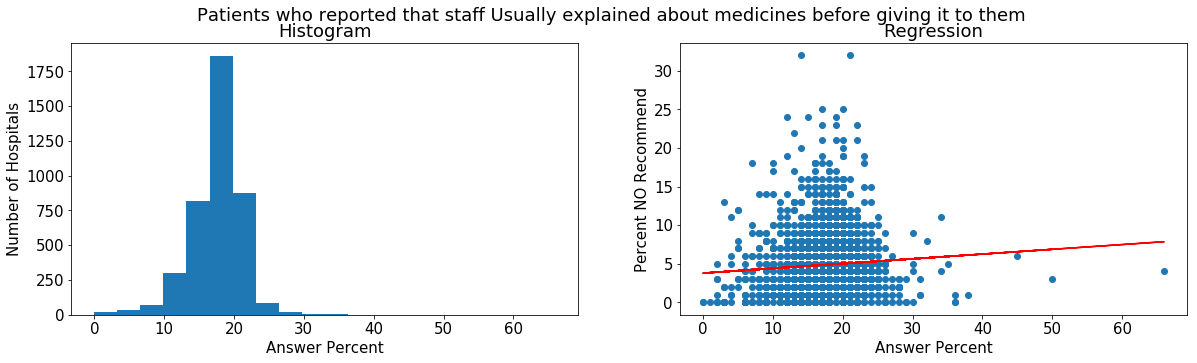

slope: 0.0616733231828 intercept: 3.79063476406 r_value: 0.0699343433123 p_value: 7.33438957351e-06 std_err: 0.0137371718928 r-squared: 0.00489081237453


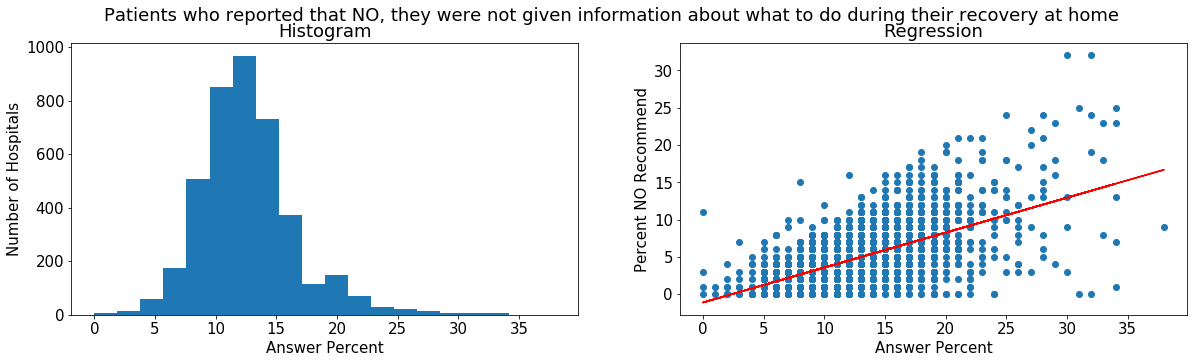

slope: 0.467887177215 intercept: -1.09417236771 r_value: 0.581088938418 p_value: 0.0 std_err: 0.0102327582629 r-squared: 0.337664354352


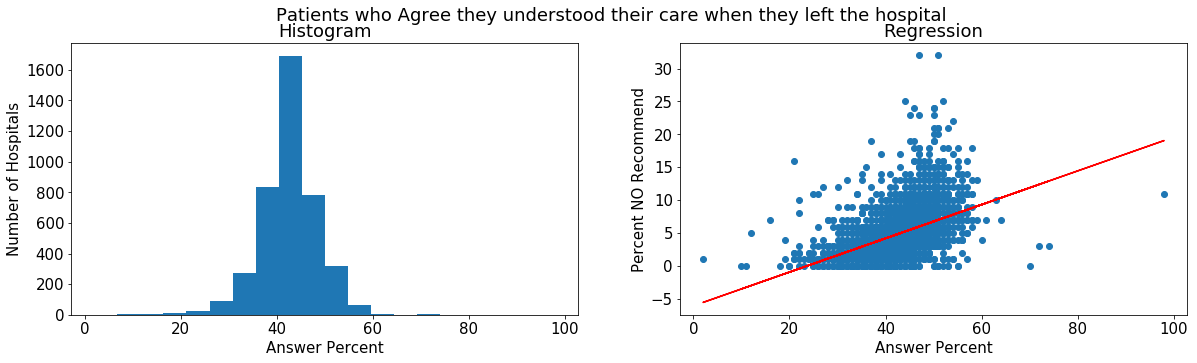

slope: 0.256269262659 intercept: -6.05009741454 r_value: 0.463722893331 p_value: 6.52981651626e-218 std_err: 0.0076456983456 r-squared: 0.2150389218


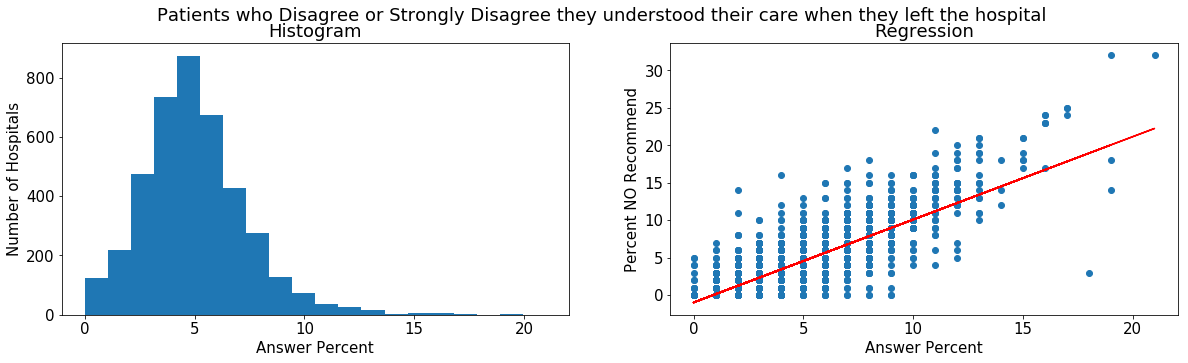

slope: 1.10594802681 intercept: -0.973064333768 r_value: 0.783379847781 p_value: 0.0 std_err: 0.0137021524116 r-squared: 0.61368398591


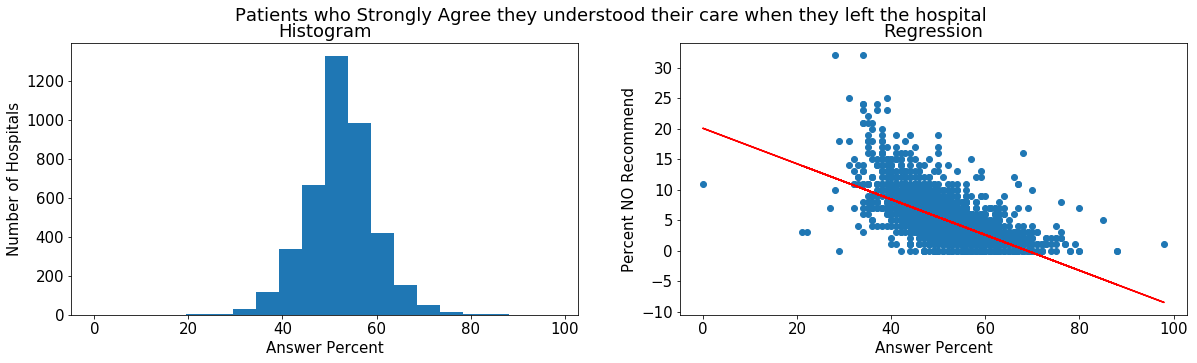

slope: -0.291345246334 intercept: 20.0496907197 r_value: -0.63728909306 p_value: 0.0 std_err: 0.00550135357279 r-squared: 0.406137388133


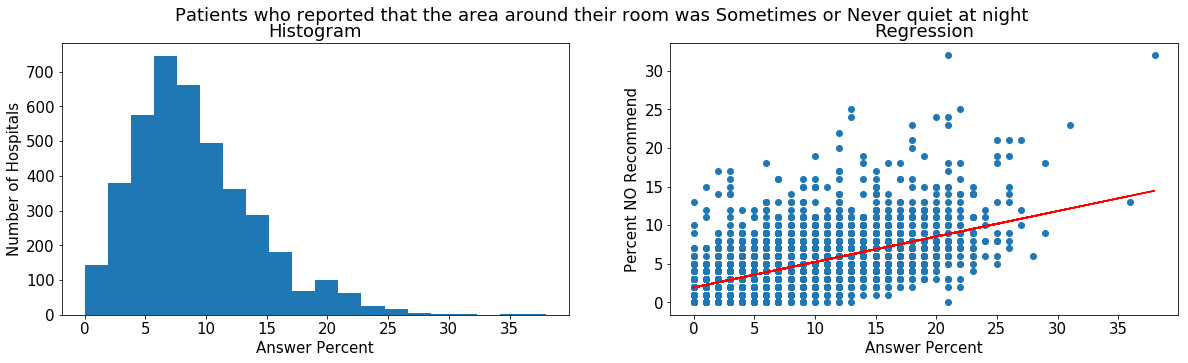

slope: 0.329988468102 intercept: 1.92643732775 r_value: 0.51632032344 p_value: 1.90530103912e-278 std_err: 0.00854690852848 r-squared: 0.266586676397


In [105]:
# Isolate Group A Questions from all survey reponses

unique_questions = df.HCAHPS_Question.unique()
GroupA_questions = []
for i in unique_questions:
    if i.find('star rating') == -1:
        if i.find('linear mean') == -1:
            if i.find('recommend') == -1:
                if i.find('rating') == - 1:
                  GroupA_questions.append(i)

# Plot histogram and regression for each Group A questions, and generate R squared list

for i in GroupA_questions:
    plot_histogram_and_regression_questions(i)

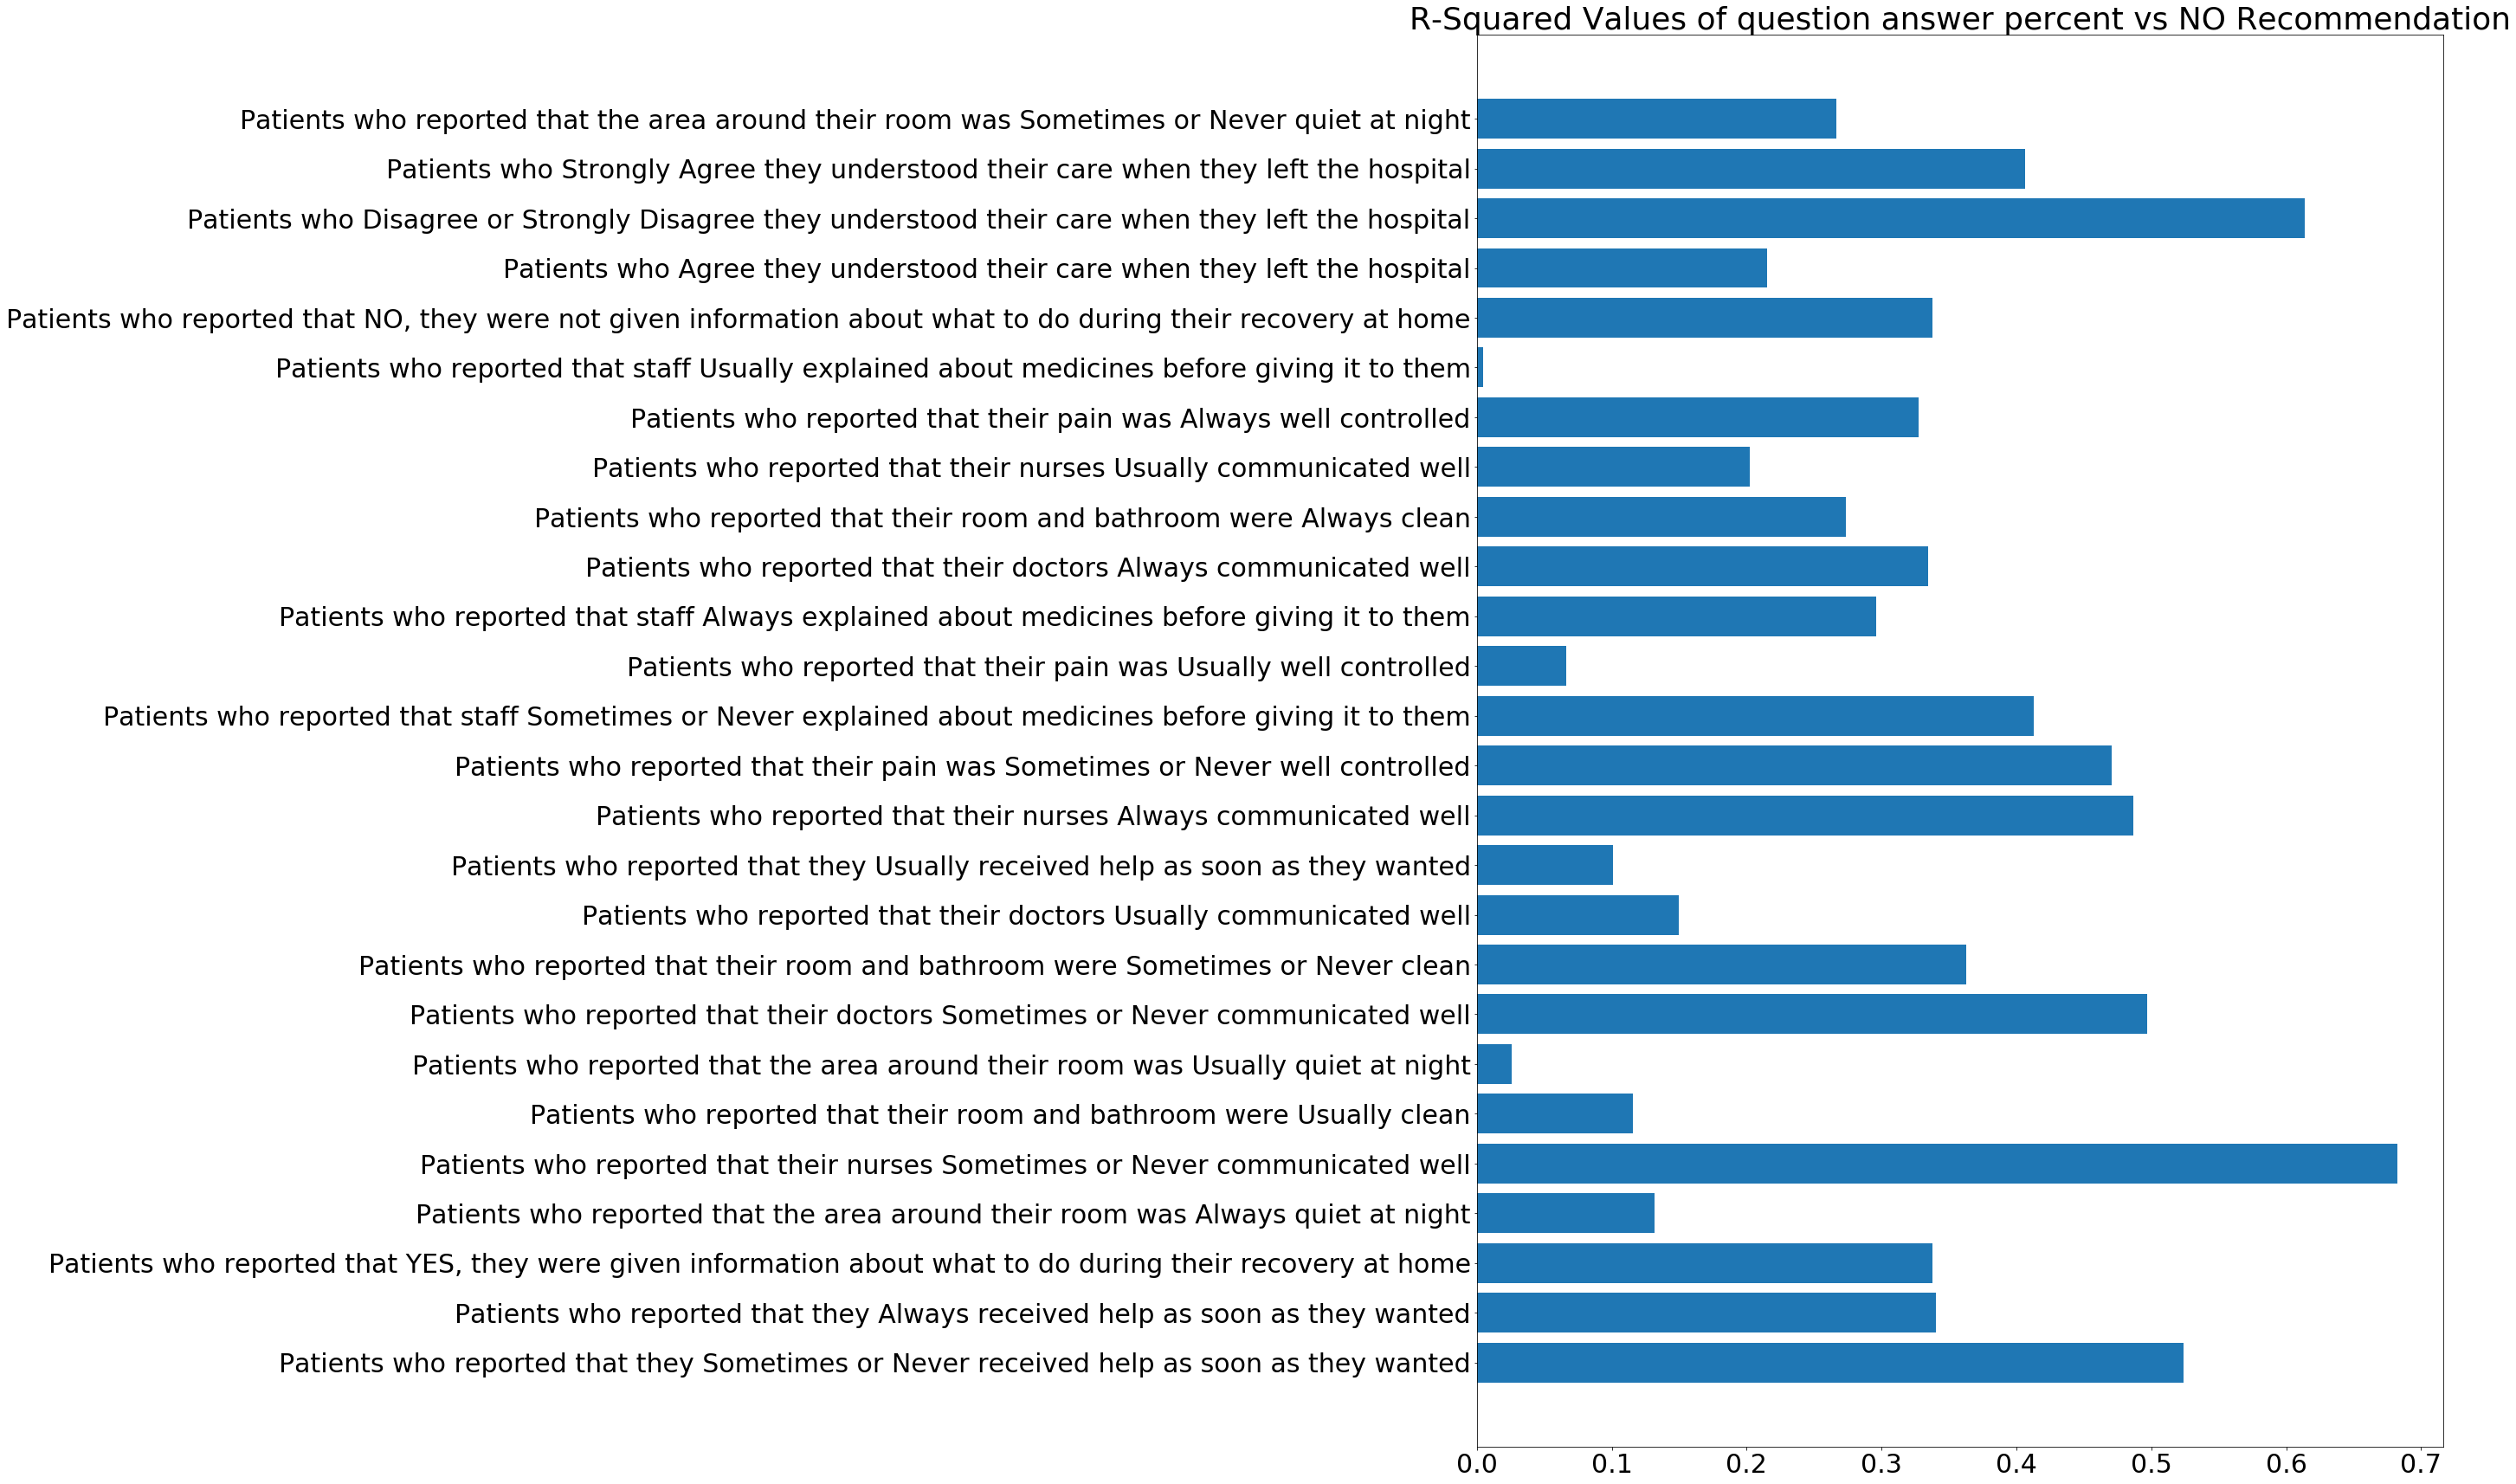

In [106]:
# Plot R Squared Values of all Answer Percent for All Questions

plt.rcParams.update({'font.size': 30})

plt.figure(figsize=(20, 30))
y_pos = np.arange(len(r2_questions))
plt.barh(y_pos, r2_values)
plt.yticks(y_pos, r2_questions)
plt.title('R-Squared Values of question answer percent vs NO Recommendation')
plt.show()
#

## Most Critical Questions According to Univariate Linear Regression:
    1. Patients who reported that their nurses Sometimes or Never communicated well
    2. Patients who disagree or strongly disagree they understood their care when they left the hospital
    3. Patients who reported they sometimes or never received help as soon as they wanted
    
Now that we have performed simple linear regression on each response independently, we will use multiple
linear regression and construct a model bnased on all reponses compared against a "NO" reccomendation.

## Linear Model Construction:

In [ ]:
# Must reorder data before creating multiple linear regression

# Create new dataframe with questions by answer percentage values

df2 = pd.DataFrame(df.Provider_ID.unique(), columns = ['Provider_ID'])
Providers = df2

def build_merged_dataframe(question, question_short):

  question_frame = df[df.HCAHPS_Question == question]
  question_frame = question_frame[question_frame.HCAHPS_Answer_Percent != 'Not Available']
  question_frame = question_frame[question_frame.HCAHPS_Answer_Percent != 'Not Applicable']

  tempdf = pd.merge(question_frame, Providers, on='Provider_ID')
  tempdf = tempdf.drop(['Hospital_Name', 'State', 'ZIP_Code', 'County_Name', 'Phone_Number','Address', 'City', 'HCAHPS_Measure_ID', 'HCAHPS_Question', 'Patient_Survey_Star_Rating', 'Patient_Survey_Star_Rating_Footnote'], axis=1)
  tempdf = tempdf.drop(['HCAHPS_Answer_Description', 'HCAHPS_Answer_Percent_Footnote', 'HCAHPS_Linear_Mean_Value', 'Number_of_Completed_Surveys', 'Number_of_Completed_Surveys_Footnote','Survey_Response_Rate_Percent',  'Measure_End_Date', 'Location'], axis=1)
  tempdf = tempdf.drop(['Survey_Response_Rate_Percent_Footnote', 'Measure_Start_Date'], axis=1)
  tempdf.columns = ['Provider_ID', question_short]
  newdf = pd.merge(tempdf, df2, on = 'Provider_ID')
  return(newdf)


# Pass each question from Group A, and give it new name with manageable size since questions are so long

df2 = build_merged_dataframe('Patients who reported that they Sometimes or Never received help as soon as they wanted', 'No_Help')
df2 = build_merged_dataframe('Patients who reported that they Always received help as soon as they wanted', 'Always_Help')
df2 = build_merged_dataframe('Patients who reported that YES, they were given information about what to do during their recovery at home', 'Yes_Info')
df2 = build_merged_dataframe('Patients who reported that the area around their room was Always quiet at night', 'Always_Quiet')
df2 = build_merged_dataframe('Patients who reported that their nurses Sometimes or Never communicated well', 'Bad_Nurse_Com')
df2 = build_merged_dataframe('Patients who reported that their room and bathroom were Usually clean', 'Usually_Clean')
df2 = build_merged_dataframe('Patients who reported that the area around their room was Sometimes or Never quiet at night', 'Not_Quiet')
df2 = build_merged_dataframe('Patients who reported that the area around their room was Usually quiet at night', 'Usually_Quiet')
df2 = build_merged_dataframe('Patients who reported that their doctors Sometimes or Never communicated well', 'Bad_Doc_Com')
df2 = build_merged_dataframe('Patients who reported that their room and bathroom were Sometimes or Never clean', 'Dirty_room')
df2 = build_merged_dataframe('Patients who reported NO, they would probably not or definitely not recommend the hospital', 'No_Rec')
df2 = build_merged_dataframe('Patients who reported that their doctors Usually communicated well', 'Usually_Doc_Com')
df2 = build_merged_dataframe('Patients who reported that they Usually received help as soon as they wanted', 'Usually_Help')
df2 = build_merged_dataframe('Patients who reported that their nurses Always communicated well', 'Always_Nurse_Com')
df2 = build_merged_dataframe('Patients who reported that their pain was Sometimes or Never well controlled', 'No_Pain_Control')
df2 = build_merged_dataframe('Patients who reported that staff Sometimes or Never explained about medicines before giving it to them', 'No_Staff_Med')
df2 = build_merged_dataframe('Patients who reported that their pain was Usually well controlled', 'Usual_Pain')
df2 = build_merged_dataframe('Patients who reported that staff Always explained about medicines before giving it to them', 'Always_Staff_Med')
df2 = build_merged_dataframe('Patients who reported that their doctors Always communicated well', 'Always_Doc_Com')
df2 = build_merged_dataframe('Patients who reported that their room and bathroom were Always clean', 'Always_Clean')
df2 = build_merged_dataframe('Patients who reported that their nurses Usually communicated well', 'Usual_Nurse_Com')
df2 = build_merged_dataframe('Patients who reported that their pain was Always well controlled', 'Pain_Always')
df2 = build_merged_dataframe('Patients who reported that staff Usually explained about medicines before giving it to them', 'Usual_Medicine')
df2 = build_merged_dataframe('Patients who reported that NO, they were not given information about what to do during their recovery at home', 'No_Info_Recover')
df2 = build_merged_dataframe('Patients who Agree they understood their care when they left the hospital', 'Mostly_Understood_Care')
df2 = build_merged_dataframe('Patients who Disagree or Strongly Disagree they understood their care when they left the hospital', 'No_Unerstood_Care')
df2 = build_merged_dataframe('Patients who Strongly Agree they understood their care when they left the hospital', 'Really_Understood_Care')



In [108]:
from sklearn.linear_model import LinearRegression
X = df2.drop(['Provider_ID', 'No_Rec'], axis = 1)

# This creates a LinearRegression object
lm = LinearRegression()
lm.fit(X, df2.No_Rec)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [109]:
# Show estimated coefficients from linear regression model
# Note: These coefficients represent the slope in the regressions, but do not account
# for confidence, and therefore do not represent the actual impact of an individual
# question on modeling how likey a patient is to register a "NO" recommendation

lr_coeffs = pd.DataFrame(list(zip(X.columns, lm.coef_)), columns = ['Questions', 'estimatedCoefficients'])
lr_coeffs

,Questions,estimatedCoefficients
0,Really_Understood_Care,2.605645e+10
1,No_Unerstood_Care,2.605645e+10
2,Mostly_Understood_Care,2.605645e+10
3,No_Info_Recover,-5.676894e+10
4,Usual_Medicine,-3.993667e+09
5,Pain_Always,-6.801026e+10
6,Usual_Nurse_Com,6.195419e+10
7,Always_Clean,3.313077e+10
8,Always_Doc_Com,6.269992e+10
9,Always_Staff_Med,-3.993667e+09


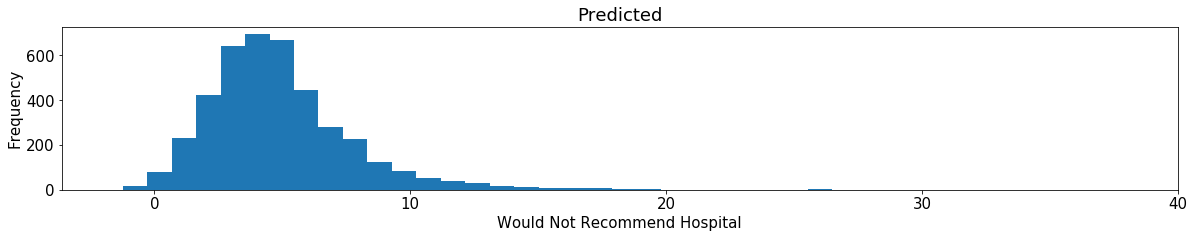

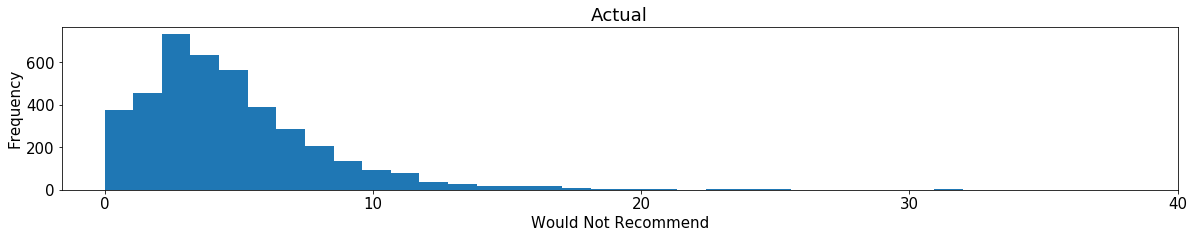

In [110]:
# Plot predicted values vs actual values

plt.rcParams.update({'font.size': 15})

plt.figure(figsize=(20, 3))
plt.hist(lm.predict(X), bins=30)
plt.xticks([0, 10, 20, 30, 40])
plt.title('Predicted')
plt.xlabel('Would Not Recommend Hospital')
plt.ylabel('Frequency')
plt.show()

int_no_rec = df2.No_Rec.astype(int)
plt.figure(figsize=(20, 3))
plt.hist(int_no_rec, bins = 30)
plt.xticks([0, 10, 20, 30, 40])
plt.xlabel('Would Not Recommend')
plt.ylabel('Frequency')
plt.title('Actual')
plt.show()


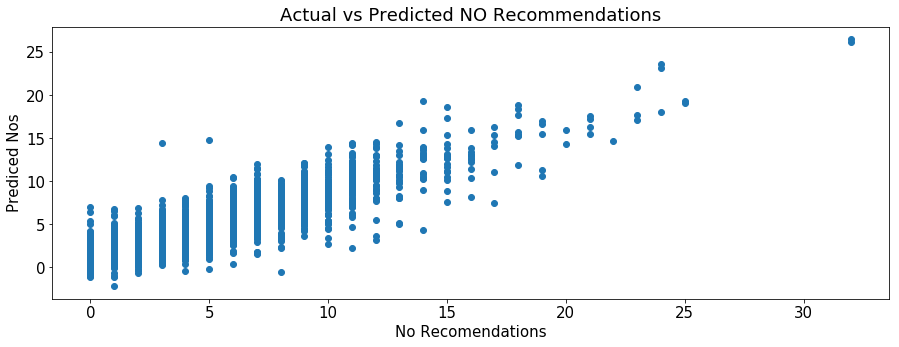

In [111]:
plt.figure(figsize=(15, 5))
plt.scatter(df2.No_Rec, lm.predict(X))
plt.xlabel("No Recomendations")
plt.ylabel("Prediced Nos")
plt.title("Actual vs Predicted NO Recommendations")
plt.show()

In [121]:

int_no_rec = df2.No_Rec.astype(int)
mseFull = np.mean((int_no_rec - lm.predict(X)) ** 2)
print('mean squred error:' , mseFull)
print('RMSE: ', math.sqrt(mseFull))


mean squred error: 2.604552616934761
RMSE:  1.6138626388062773


## Linear Model Fit:

An RMSE of 1.6 means that using quesiton responses, our model predicts the "NO" recommendation response
with an average error of 1.6 percentage points.  This suggests our model performs reasonably well.

We will cross validate with a residuals test by dividing data into training and testing sets, and 
verify that the model performs well.

(3077, 26)
(1026, 26)
(3077,)
(1026,)
RMSE with test data:  1.6088473235932172
RMSE with trainig data  1.633661168904889


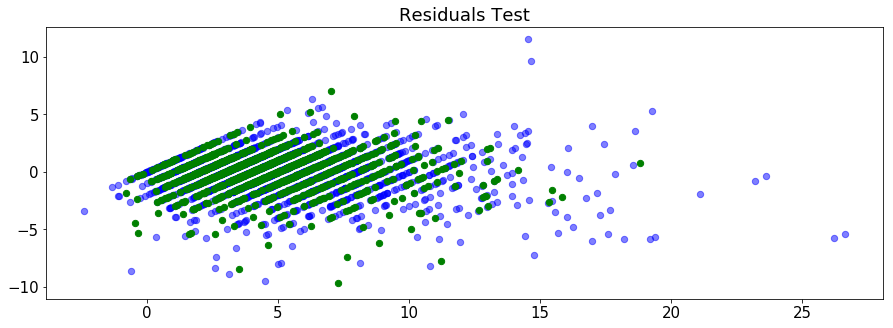

In [122]:
# Split data into train and test subsets, and graph residuals

df2_int_norec = df2.No_Rec.astype(int)

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, df2_int_norec)
lm.fit(X_train,Y_train)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

lm.fit(X_train,Y_train)

print("RMSE with test data: ", math.sqrt(np.mean((Y_train - lm.predict(X_train)) ** 2)))
print("RMSE with trainig data ", math.sqrt(np.mean((Y_test - lm.predict(X_test)) ** 2)))

plt.figure(figsize=(15, 5))
plt.title('Residuals Test')
plt.scatter(lm.predict(X_train), lm.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(lm.predict(X_test), lm.predict(X_test) - Y_test, c='g', s=40)
plt.show()

## Residuals Test

The data is divided into training data (blue), and test data (green).  The green test data appears
randomly distributed which indicates a good fit.  The RMSE values of 1.61 (training date) and 
1.63 (test data) further suggest our model is a good fit. 

## Recrusive Feature Elimination (RFE)

We will now use recursive feature elimination to determine the most important question responses 
according to our linear model.  Recursive feature elimination works by systematically exploring
the linear model with individual reponses removed.  It determines which reponses have the least
predictive value, and then sorts reponses according to which had the greatest impact on model accuracy.

In [114]:
# Use recursive feature elimination to find most useful and least useful questions in model prediction

from sklearn.feature_selection import RFE

lm.fit(X, df2.No_Rec)

rfe = RFE(lm, n_features_to_select=1)
rfe.fit(X,int_no_rec)

RFE_result = pd.DataFrame(list(zip(X.columns, rfe.ranking_)), columns = ['Questions', 'RFE Ranking'])
RFE_result.sort_values(by='RFE Ranking', ascending=-1)

,Questions,RFE Ranking
21,Bad_Nurse_Com,1
6,Usual_Nurse_Com,2
13,Always_Nurse_Com,3
5,Pain_Always,4
10,Usual_Pain,5
12,No_Pain_Control,6
15,Usually_Doc_Com,7
8,Always_Doc_Com,8
17,Bad_Doc_Com,9
23,Yes_Info,10


## RFE Differences from Simple Regression Analysis

In our simple regression analysis we found specific negative reponses that were most highly correlated
with a "NO" recommendation.  However with our linear model and RFE, we see that response categories
are grouped together in determining how well they predict a patient's negative hospital experience.  Using
RFE we can determine which question categories are having the greatest impact on overall patient satisfaction.

# Conclusion

RFE groups questions by type showing which factors are having biggest impact on patients' non recommendation
of hostpial.

Questions driving bad experiences are:
    
    1. Nurse Communication
    2. Pain Management
    3. Doctor Communication
    4. Recovery Information
    5. Room and Bathroom Cleanliness
    6. Understanding of Care on Leaving Hospital
    7. Timely Help When Wanted
    8. Quietness at Night
    9. Staff Explanations of Medicines
